# Estimating overall rates and yields from pseudo batch transformed data

This tutorial will show how to use the fedbatch data correction package to calculate rates and yields from measurements. We will use simulated data to showcase the workflow. The simulated data here resembles a system where online measurements are available. This could for example to the Satorious AMBR(R) or M2Lab Bio/Robolector cultivation systems.

## loading fedbatch data

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm

from pseudobatch import pseudobatch_transform_pandas
from pseudobatch.datasets import load_standard_fedbatch

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


First, we will load the standard fed-batch process dataset and take only the time points where a sample was take

In [8]:
fedbatch_df_measurement = load_standard_fedbatch(sampling_points_only=True)

Lets start with getting an overview of the data that we have imported by look at a part of the dataframe.

In [9]:
(fedbatch_df_measurement
    .filter(['timestamp', 'sample_volume', 'c_Biomass', 'c_Glucose', 'c_Product', 'v_Volume', 'v_Feed_accum'])
    .head()
)

,timestamp,sample_volume,c_Biomass,c_Glucose,c_Product,v_Volume,v_Feed_accum
0,10.000000,100.0,1.337854,0.075012,0.694737,1015.906036,15.906036
1,14.545455,100.0,2.078116,0.075010,1.308552,928.960902,28.960902
2,19.090909,100.0,3.203015,0.075111,2.241303,847.314262,47.314262
3,23.636364,100.0,4.879772,0.075020,3.631646,772.816654,72.816654
4,28.181818,100.0,7.307921,0.075064,5.645033,707.795685,107.795685


This shows some of the columns in the dataframe. 
- `sample_volume` columns contain the sample volume at the given time point. In this dataset, we have online measurements thus more measurements than samples and therefore at most timepoint the sample volume is 0.
- `timestamp` describe the timepoint
- `c_Biomass`, `c_Glucose`, and `c_Product` is the online concentration measurements 
- `v_Volume` is the volume of the bioreactor. **IMPORTANT:** at points where a sample is taken this value represents the volume just **before** the sample was drawn.
- `v_Feed_accum` is the accumulated feed added until that timepoint.
- `m_Biomass`, `m_Glucose`, `m_Product` is the total mass of that species in the reactor, i.e. volume * concentration

The dataframe does contain more columns than those shown, but these simply contain information about the parameters used for simulation. Some of them, e.g. true maximum growth rate, are typically not know in a real experimental setting and some of them are experimental design parameters, e.g. glucose concentration in the feed. For clarity, we will just print them here:

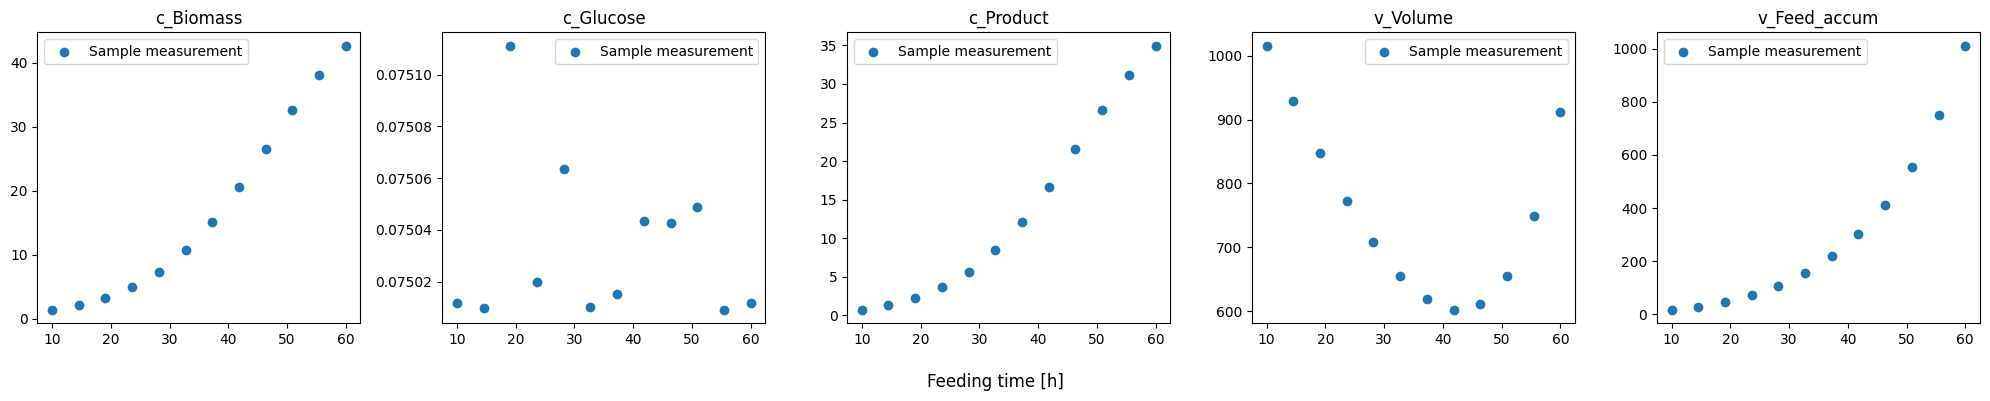

In [10]:
plot_columns = ["c_Biomass", "c_Glucose", "c_Product", "v_Volume", "v_Feed_accum"]

fig, axes = plt.subplots(nrows = 1, ncols = len(plot_columns), figsize=(20, 4))
for ax, column in zip(axes.ravel(), plot_columns):
    ax.scatter(fedbatch_df_measurement["timestamp"], fedbatch_df_measurement[column], label="Sample measurement")
    ax.title.set_text(column)
    ax.legend()
fig.supxlabel("Feeding time [h]")
fig.tight_layout()

In the simulated data, we clearly see the discrete nature of the product, glucose and biomass mass' and the volume of bioreactor. This is due to sample withdrawal of reactor. This "continuos" time series would be available for some quantities, such as Biomass, O2, CO2, and volume, in some cultivation systems, e.g. Robolector or AMBR systems. Glucose and product measurements will typically only be available as the much sparser measurement points. The pseudo batch transformation can handle both online measurements and sample measurements.

## Applying the pseudo batch transformation

Now we can transform the data. Here I will use a convenience wrapper function that can be applied directly to a Pandas DataFrame, but under the hood this just loops over a list of columns and calls the `pseudobatch_transform()` on each of them.

In [11]:
glucose_in_feed = 100

fedbatch_df_measurement[["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo", "c_CO2_pseudo"]] = pseudobatch_transform_pandas(
    fedbatch_df_measurement,
    measured_concentration_colnames=["c_Biomass", "c_Glucose", "c_Product", "c_CO2"],
    reactor_volume_colname="v_Volume",
    accumulated_feed_colname="v_Feed_accum",
    sample_volume_colname="sample_volume",
    concentration_in_feed=[0, glucose_in_feed, 0, 0],
)

## Calculate growth rate

Now we are ready to estimate the growth rate. To estimate the growth rate we will use a log-linear model.
$$
log(C^{\star}_{Biomass}) = a + \hat\mu * t
$$
where $C^{\star}_{Biomass}$ is the pseudo batch transformed biomass concentration, and $\hat\mu$ is the growth rate estimate. Because we will fit several linear models, we make a small convenience function to simplify the code.

In [13]:
def fit_ols_model(formula_like: str, data: pd.DataFrame) -> sm.regression.linear_model.RegressionResultsWrapper:
    y, X = dmatrices(formula_like, data)
    model = sm.OLS(endog=y, exog=X)
    res = model.fit()
    return res

Now we can fit the growth rate for both the pseudo batch transformed and the raw biomass data.

In [15]:
# fitting a linear model to the pseudo batch transformed biomass
res_mu_hat_pseudo = fit_ols_model("np.log(c_Biomass_pseudo) ~ timestamp", fedbatch_df_measurement)

# fitting a linear model to the raw biomass
res_mu_hat_raw = fit_ols_model("np.log(m_Biomass) ~ timestamp", fedbatch_df_measurement)

# save the growth rate estimates
mu_hat_pseudo = res_mu_hat_pseudo.params[1]
mu_hat_raw = res_mu_hat_raw.params[1]

print("Fitted growth rate from pseudo batch transformed biomass: " + str(mu_hat_pseudo))
print("Fitted growth rate from raw biomass: " + str(mu_hat_raw))
print("True simulated growth rate " + str(fedbatch_df_measurement["mu_true"].iloc[-1]))

Fitted growth rate from pseudo batch transformed biomass: 0.10000016643815146
Fitted growth rate from raw biomass: 0.06597174185227486
True simulated growth rate 0.1000104046529978


We see that the growth rate fitted to the pseudo batch data is very close to the true growth rate. The small difference originates from the fact that the growth rate in the simulation is not truly constant, but changes slightly due to substrate concentration changing slightly. On the other hand the growth rate estimate from the raw measurements in very wrong.

## Estimating biomass yield coefficients
The biomass yield coefficients can also be estimated from the pseudo batch transformed data. Here we will fit a normal linear model to obtain a single overall yield estimate for each species.
$$
C^{\star}_{Species} = a + \hat Y_{xspecies} * C^{\star}_{Biomass}
$$

Where $C^{\star}_{Species}$ is the pseudo concetration of a species and the $\hat Y_{xspecies}$ is the biomass yield coefficient (in units $\frac{g_{Species}}{g_{Biomass}}$).

We will start by estimating the substrate biomass yield coefficient. Also we will use the convention that yield coefficients are strictly positive.

In [20]:
# res_yxs_noncorrected = fit_ols_model(formula_like = "m_Glucose_consumed ~ m_Biomass", data= fedbatch_df_measurement)
res_yxs_corrected = fit_ols_model(formula_like = "c_Glucose_pseudo ~ c_Biomass_pseudo", data= fedbatch_df_measurement)

# yxs_noncorrected = res_yxs_noncorrected.params[1]
yxs_corrected = np.abs(res_yxs_corrected.params[1])

# print(f"Fitted Yxs from raw data: {yxs_noncorrected.round(5)}")
print(f"Fitted Yxs from pseudo batch transformed data: {yxs_corrected.round(5)}")
print(f"True Yxs: {fedbatch_df_measurement.Yxs.iloc[0].round(5)}")

Fitted Yxs from pseudo batch transformed data: 1.85
True Yxs: 1.85


To estimate the biomass yield of a substrate using the raw data we first need to calculate the consumed substrate (notice that this was NOT required using the pseudo batch transformed data). For the sake brevity we will skip this calculation in the tutorial to see how it can be done please refer to [this notebook](../../../article/notebooks/2.0-vikhes-investigate-test-data-set.ipynb). 

Now let's move on the product biomass yield coefficient.

In [24]:
res_yxp_noncorrected = fit_ols_model(formula_like = "m_Product ~ m_Biomass", data= fedbatch_df_measurement)
res_yxp_corrected = fit_ols_model(formula_like = "c_Product_pseudo ~ c_Biomass_pseudo", data= fedbatch_df_measurement)

yxp_noncorrected = res_yxp_noncorrected.params[1]
yxp_corrected = res_yxp_corrected.params[1]

print(f"Fitted Yxp from raw data: {yxp_noncorrected.round(5)}")
print(f"Fitted Yxp from pseudo batch transformed data: {yxp_corrected.round(5)}")
print(f"True Yxp: {fedbatch_df_measurement.Yxp.iloc[0].round(5)}")

Fitted Yxp from raw data: 0.82967
Fitted Yxp from pseudo batch transformed data: 0.82151
True Yxp: 0.82151


Again the estimate based on the pseudo batch transformed data is more accurate that the estimate based on the raw data. In this case the difference the improvement of the estimate with the pseudo batch data is not as significant as for the growth rate, never the less it is still more accurate.

## Overall specific uptake/secretion rates
Once we have calculated the yields and the growth rate it is easy to calculate the remaining uptake/secretion rates ($r_{species}$) assuming that the consumption and production is growth coupled.

$$
r_{species} = \mu * Y_{xspecies}
$$

Lets start with the specific production rate

In [25]:
r_p_corrected = mu_hat_pseudo * yxp_corrected
r_p_raw = mu_hat_raw * yxp_noncorrected
r_p_true = fedbatch_df_measurement.mu_true.iloc[0] * fedbatch_df_measurement.Yxp.iloc[0]

print(f"Fitted r_p from pseudo batch transformed data: {r_p_corrected.round(5)}")
print(f"Fitted r_p from raw data: {r_p_raw.round(5)}")
print(f"True r_p: {r_p_true.round(5)}")

Fitted r_p from pseudo batch transformed data: 0.08215
Fitted r_p from raw data: 0.05474
True r_p: 0.08216


And the specific glucose uptake rate

In [26]:
r_s_corrected = mu_hat_pseudo * yxs_corrected
r_s_true = fedbatch_df_measurement.mu_true.iloc[0] * fedbatch_df_measurement.Yxs.iloc[0]

print(f"Fitted r_s from pseudo batch transformed data: {r_s_corrected.round(5)}")
print(f"True r_s: {r_s_true.round(5)}")

Fitted r_s from pseudo batch transformed data: 0.185
True r_s: 0.18502


The specific rates calculated from the pseudo batch transformed data is correct to the four decimal point. Where as the specific rates calculated from the non corrected data are incorrect. In the next tutorial we will show how time series estimates of rates and yields based on pseudo batch transformed data. Continue [here](./3%20-%20Estimate%20time%20series%20parameters.ipynb).